In [1]:
import os
import math
import torch
from transformers import AutoTokenizer, CLIPTextModel
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers.schedulers import DDPMScheduler
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from peft import LoraConfig, get_peft_model
from torchvision.transforms.functional import resize

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from accelerate import Accelerator
# from torch.cuda.amp import autocast, GradScaler
from torch.amp import autocast, GradScaler
from diffusers.models import UNet2DConditionModel
from diffusers import StableDiffusionPipeline

import torch.optim as optim
from diffusers.schedulers import DDPMScheduler
from accelerate import Accelerator
from tqdm.auto import tqdm

from torch.nn.functional import pad

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class DefectDataset(Dataset):
    def __init__(self, image_dir, mask_dir, caption_file_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.caption_file_dir = caption_file_dir
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        mask_name = image_name.split(".")  # Assuming mask has the same name
        mask_name = mask_name[0] + "_rbg_mask." + mask_name[1]
        caption_file_name = os.path.splitext(image_name)[0] + '.txt'

        image_path = os.path.join(self.image_dir, image_name)
        mask_path = os.path.join(self.mask_dir, mask_name)
        caption_path = os.path.join(self.caption_file_dir, caption_file_name)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Single-channel mask
        with open(caption_path, "r") as f:
            caption = f.read().strip()

        # Apply transformations
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask, caption

In [3]:

# Define your data directories
image_directory = '../dataset/bottle/image/'
mask_directory = '../dataset/bottle/rbg_mask/'
caption_directory = '../dataset/bottle/captions/'

# Define image transformations (resize, normalize)
# Define transformations for images
image_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize for RGB images
    transforms.Lambda(lambda x: x.half())  # Cast to torch.float16
])

# Define transformations for masks
mask_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),  # Convert mask to tensor without normalization
    transforms.Lambda(lambda x: x.half())  # Cast to torch.float16

])

# Create the dataset
dataset = DefectDataset(image_directory, mask_directory, caption_directory, image_transform=image_transform, mask_transform=mask_transform)

In [4]:
# Example of accessing an item
image, mask, caption = dataset[0]
print(f"Image shape: {image.shape}, Mask shape: {mask.shape}, Caption: {caption}")

# You'll then need to create DataLoaders for training and validation
from torch.utils.data import DataLoader, random_split

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2)

Image shape: torch.Size([3, 512, 512]), Mask shape: torch.Size([1, 512, 512]), Caption: The image shows a top-down view of a bottle, looking from the bottle's neck towards the bottom, with a white background. The bottom right corner has a large breakage defect, shaped like a quarter of a ring, in black color.


In [5]:
def get_dataloader(image_directory, mask_directory, caption_directory, batch_size=1):

    dataset = DefectDataset(image_directory, mask_directory, caption_directory, image_transform=image_transform, mask_transform=mask_transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [6]:
accelerator = Accelerator()
dataloader = get_dataloader(image_directory, mask_directory, caption_directory)
dataloader = accelerator.prepare(dataloader)

In [7]:
dataloader

In [8]:
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.text_encoder.to("cpu")  # Move text encoder to CPU
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")
pipe.safety_checker = None

# Tokenize and encode captions
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder.to("cuda")  # Ensure text encoder is on GPU

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [9]:
# Apply LoRA
lora_config = LoraConfig(
    r=4,
    lora_alpha=8,
    target_modules=["to_q", "to_k", "to_v", "to_out.0"],
    lora_dropout=0.1,
    bias="none"
)
unwrapped_model = pipe.unet
lora_model = get_peft_model(unwrapped_model, lora_config)

# Optimizer and GradScaler
optimizer = optim.AdamW(lora_model.parameters(), lr=1e-4)
scaler = GradScaler()

In [10]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [11]:
# noisy_latents.shape, timesteps.shape

In [12]:
# captions

In [13]:
def preprocess_captions(captions, max_length=77):
    inputs = tokenizer(
        captions,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    input_ids = inputs.input_ids.to("cuda")
    attention_mask = inputs.attention_mask.to("cuda")
    
    # Encode captions into embeddings
    encoder_hidden_states = text_encoder(input_ids, attention_mask)[0]
    return encoder_hidden_states

## Training without using masks

In [19]:
accumulation_steps = 1  # Simulate a batch size of 4 * 4 = 16
for epoch in range(10):
    for batch in dataloader:
        optimizer.zero_grad()
        
        # Extract batch data
        images, masks, captions = batch #batch["image"], batch["mask"], batch["caption"]
        
        # Ensure inputs are in torch.float16 and moved to GPU
        images = images.half().to("cuda")
        masks = masks.half().to("cuda")
        
        # Encode images into latent space
        latents = pipe.vae.encode(images).latent_dist.sample()
        
        # Generate noise and noisy latents
        noise = torch.randn_like(latents)
        timesteps = torch.randint(0, pipe.scheduler.num_train_timesteps, (latents.shape[0],), device=latents.device).long()
        noisy_latents = pipe.scheduler.add_noise(latents, noise, timesteps)
        
        # Preprocess captions
        encoder_hidden_states = preprocess_captions(captions)
        
        # Predict noise
        output = lora_model(noisy_latents, timesteps, encoder_hidden_states=encoder_hidden_states)
        noise_pred = output[0]  # Adjust based on output structure
        
        # Compute loss
        loss = torch.nn.functional.mse_loss(noise_pred, noise)
        loss.backward()
        optimizer.step()
    
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 1.2890625
Epoch 0, Loss: 1.2236328125
Epoch 0, Loss: 1.5576171875
Epoch 0, Loss: 1.0302734375
Epoch 0, Loss: 1.93359375
Epoch 0, Loss: 0.63525390625
Epoch 0, Loss: 0.394775390625
Epoch 0, Loss: 0.2066650390625
Epoch 0, Loss: 1.20703125
Epoch 0, Loss: 1.486328125
Epoch 0, Loss: 0.272705078125
Epoch 0, Loss: 0.430908203125
Epoch 0, Loss: 1.18359375
Epoch 0, Loss: 0.328125
Epoch 0, Loss: 0.2479248046875
Epoch 0, Loss: 1.37890625
Epoch 0, Loss: 0.348876953125
Epoch 0, Loss: 1.326171875
Epoch 0, Loss: 0.31689453125
Epoch 0, Loss: 1.822265625
Epoch 0, Loss: 0.3310546875
Epoch 0, Loss: 1.0595703125
Epoch 0, Loss: 1.296875
Epoch 0, Loss: 0.916015625
Epoch 0, Loss: 0.560546875
Epoch 0, Loss: 1.2294921875
Epoch 0, Loss: 0.84423828125
Epoch 0, Loss: 0.465576171875
Epoch 0, Loss: 0.89013671875
Epoch 0, Loss: 0.254638671875
Epoch 0, Loss: 0.94091796875
Epoch 0, Loss: 0.8955078125
Epoch 1, Loss: 0.9619140625
Epoch 1, Loss: 1.2587890625
Epoch 1, Loss: 1.0283203125
Epoch 1, Loss: 1.0722

In [20]:
from peft import LoraConfig, get_peft_model

# Assuming `lora_model` is your fine-tuned model
output_dir = "../outputs/"
lora_model.save_pretrained(output_dir)
print(f"LoRA weights saved to {output_dir}")

LoRA weights saved to ../outputs/


In [21]:
# Save the full pipeline
pipeline_output_dir = "../pipeline-output"
pipe.save_pretrained(pipeline_output_dir)
print(f"Full pipeline saved to {pipeline_output_dir}")

Full pipeline saved to ../pipeline-output


## Inference: without masks

In [22]:
len(train_dataset), len(val_dataset)

(50, 13)

Generating image for prompt: The image shows a top-down view of a bottle, looking from the bottle's neck towards the bottom, with a white background. The lower half has a large breakage defect, shaped like half a ring, in black color.


C:\Users\adity\AppData\Local\Temp\ipykernel_22120\1071229489.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Image saved as generated_image_0.png
Generating image for prompt: The image shows a top-down view of a bottle, looking from the bottle's neck towards the bottom, with a white background. The lower half has a large breakage defect, shaped like half an irregular ring, in black color.


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Image saved as generated_image_1.png
Generating image for prompt: The image shows a top-down view of a bottle, looking from the bottle's neck towards the bottom, with a white background. Inside the bottle, there is a circular black fabric contaminant.


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Image saved as generated_image_2.png
Generating image for prompt: The image shows a top-down view of a bottle, looking from the bottle's neck towards the bottom, with a white background. The left half has a large breakage defect, shaped like half a ring, in black color.


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Image saved as generated_image_3.png
Generating image for prompt: The image shows a top-down view of a bottle, looking from the bottle's neck towards the bottom, with a white background. The upper half has a large breakage defect, shaped like half a ring, in black color.


  0%|          | 0/20 [00:00<?, ?it/s]

Image saved as generated_image_4.png
Generating image for prompt: The image shows a top-down view of a bottle, looking from the bottle's neck towards the bottom, with a white background. The upper right corner has a large breakage defect, shaped like a small part of a ring, with the middle in gold color and the sides in black color.


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
Token indices sequence length is longer than the specified maximum sequence length for this model (101 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['left corner has a small breakage defect , shaped like a small part of an irregular rectangle , in black color .']


Image saved as generated_image_5.png
Generating image for prompt: The image shows a top-down view of a bottle, looking from the bottle's neck towards the bottom, with a white background. The upper left corner has a large breakage defect, shaped like a small part of an irregular ring, in gold color. The middle of the left half has a small breakage defect, circular in shape, in gold color. The lower left corner has a small breakage defect, shaped like a small part of an irregular rectangle, in black color.


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Image saved as generated_image_6.png
Generating image for prompt: The image shows a top-down view of a bottle, looking from the bottle's neck towards the bottom, with a white background. Extending downwards inside the bottle, there is a larger twist-like shaped yellow fabric contaminant.


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Image saved as generated_image_7.png
Generating image for prompt: The image shows a top-down view of a bottle, looking from the bottle's neck towards the bottom, with a white background. The upper right corner has a large breakage defect, shaped like a quarter of a ring, in black color.


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Image saved as generated_image_8.png
Generating image for prompt: The image shows a top-down view of a bottle, looking from the bottle's neck towards the bottom, with a white background. Inside the bottle, there is a circular yellow fabric contaminant.


  0%|          | 0/20 [00:00<?, ?it/s]

Image saved as generated_image_9.png
Generating image for prompt: The image shows a top-down view of a bottle, looking from the bottle's neck towards the bottom, with a white background. The left half has a large breakage defect, shaped like half a ring, in black color.


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Image saved as generated_image_10.png
Generating image for prompt: The image shows a top-down view of a bottle, looking from the bottle's neck towards the bottom, with a white background. The upper left corner has a small breakage defect, shaped like a small part of a ring, in black color.


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Image saved as generated_image_11.png
Generating image for prompt: The image shows a top-down view of a bottle, looking from the bottle's neck towards the bottom, with a white background. The lower right corner has a large breakage defect, shaped like a small part of a ring, in black color.


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Image saved as generated_image_12.png


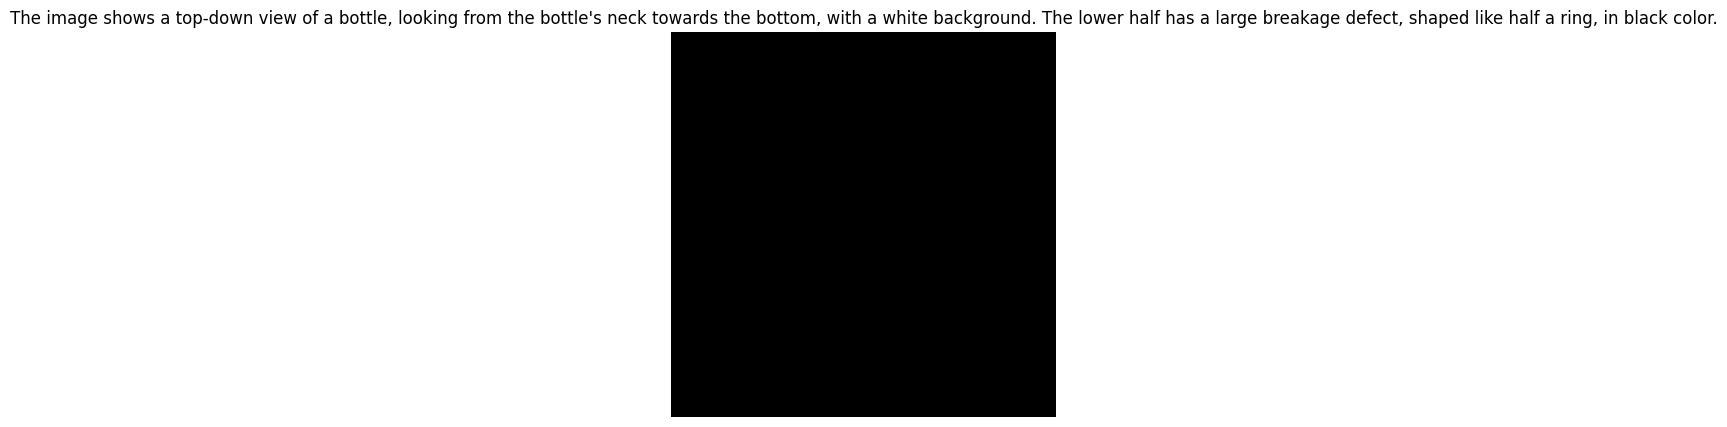

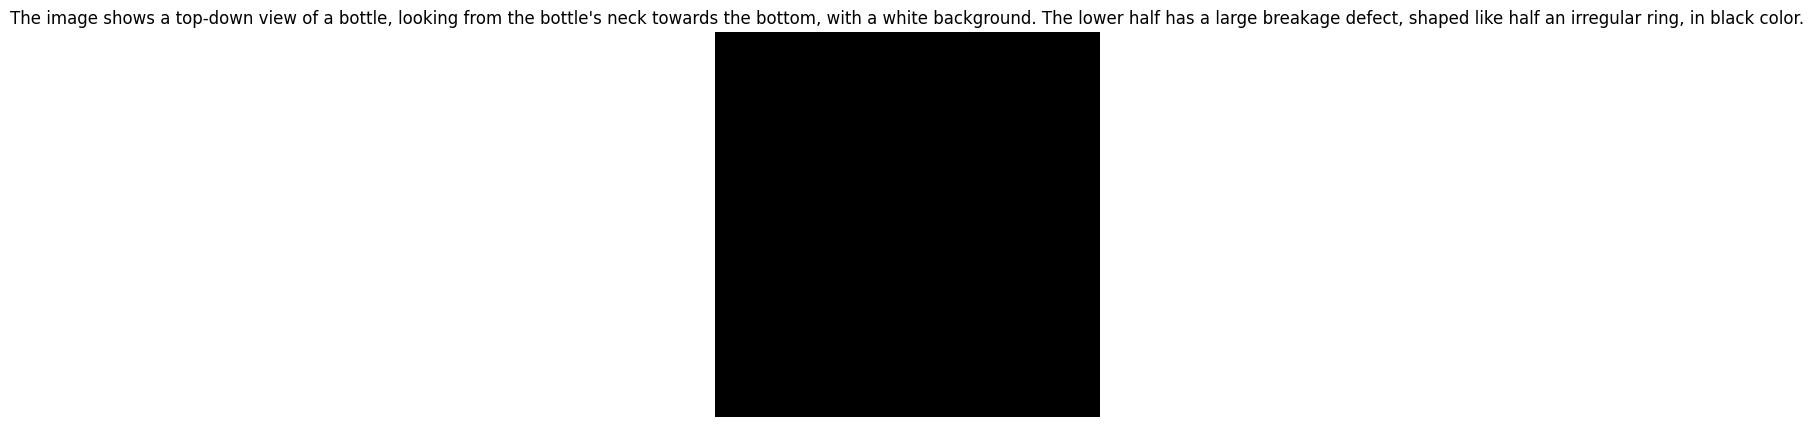

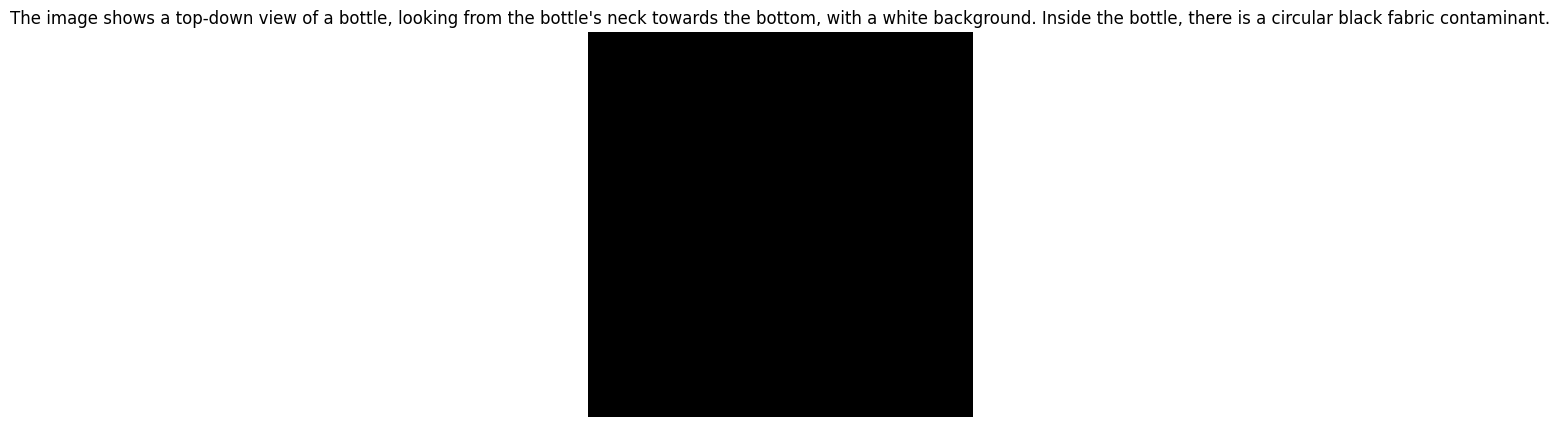

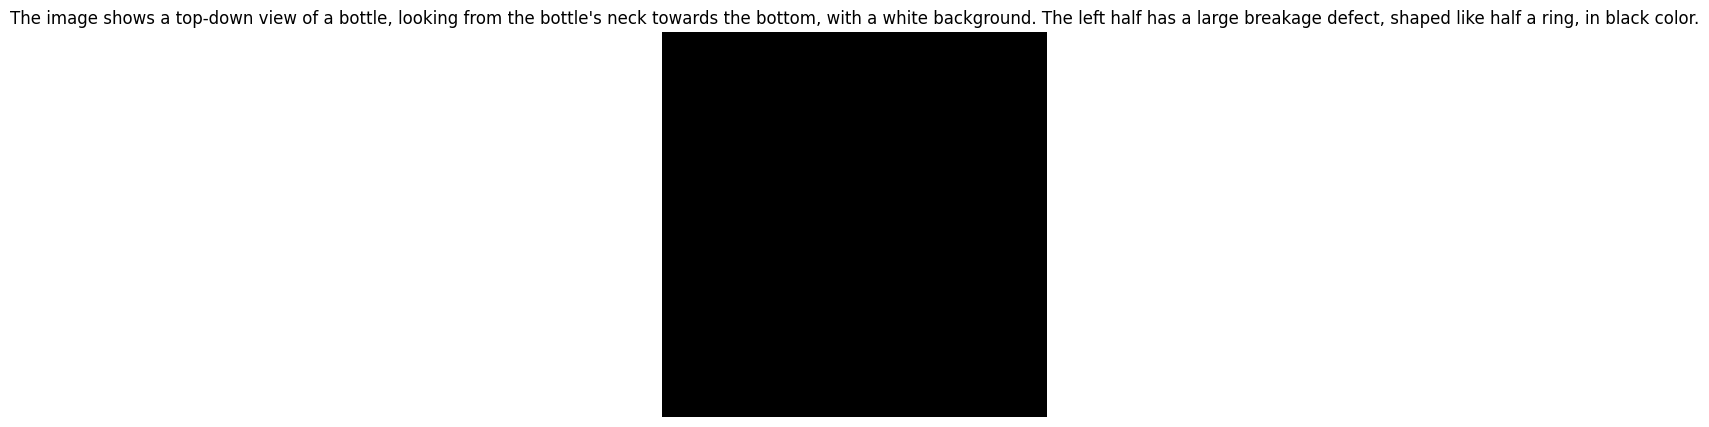

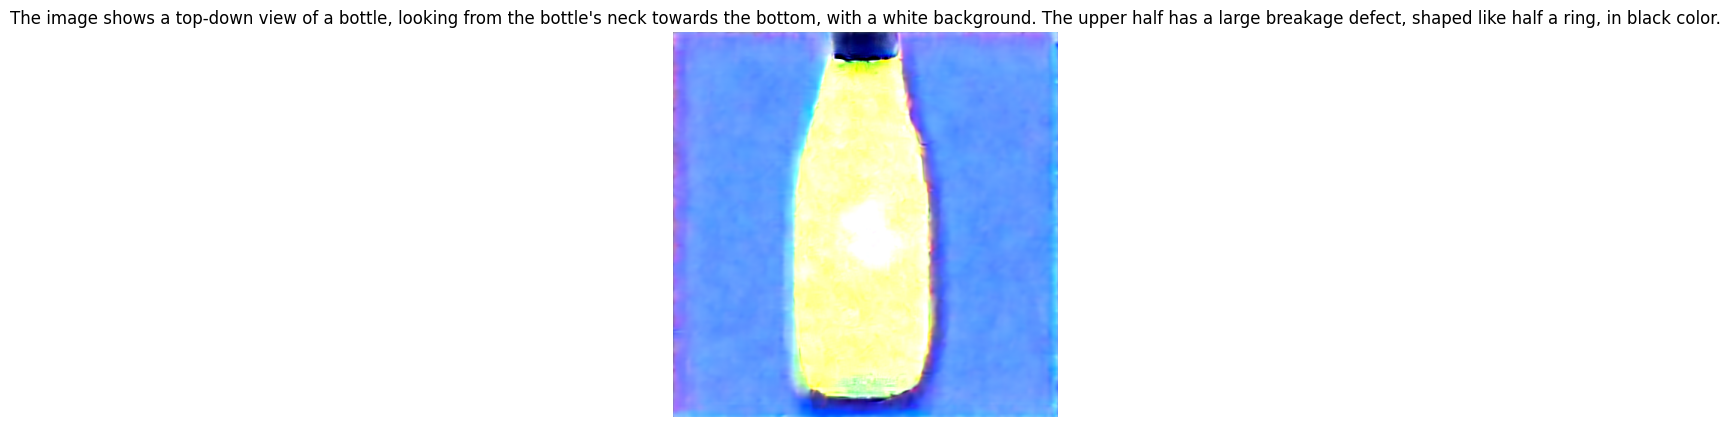

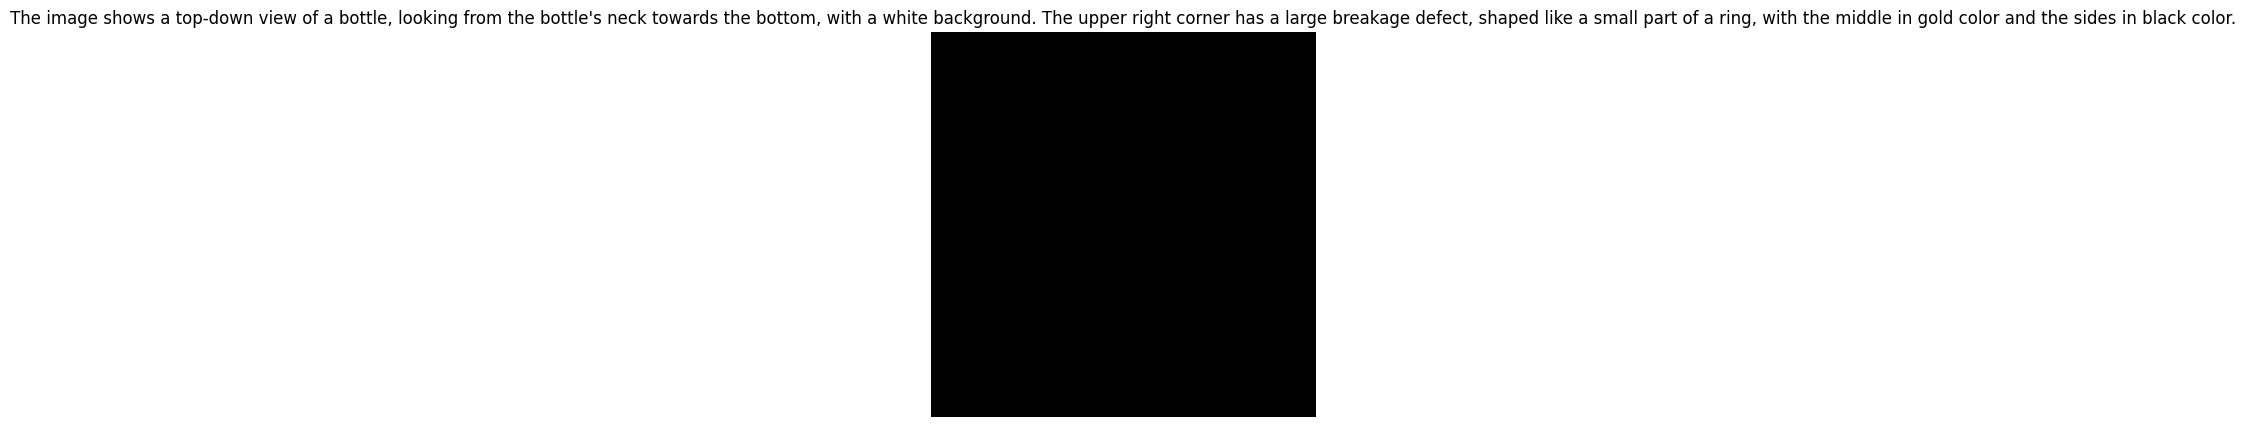

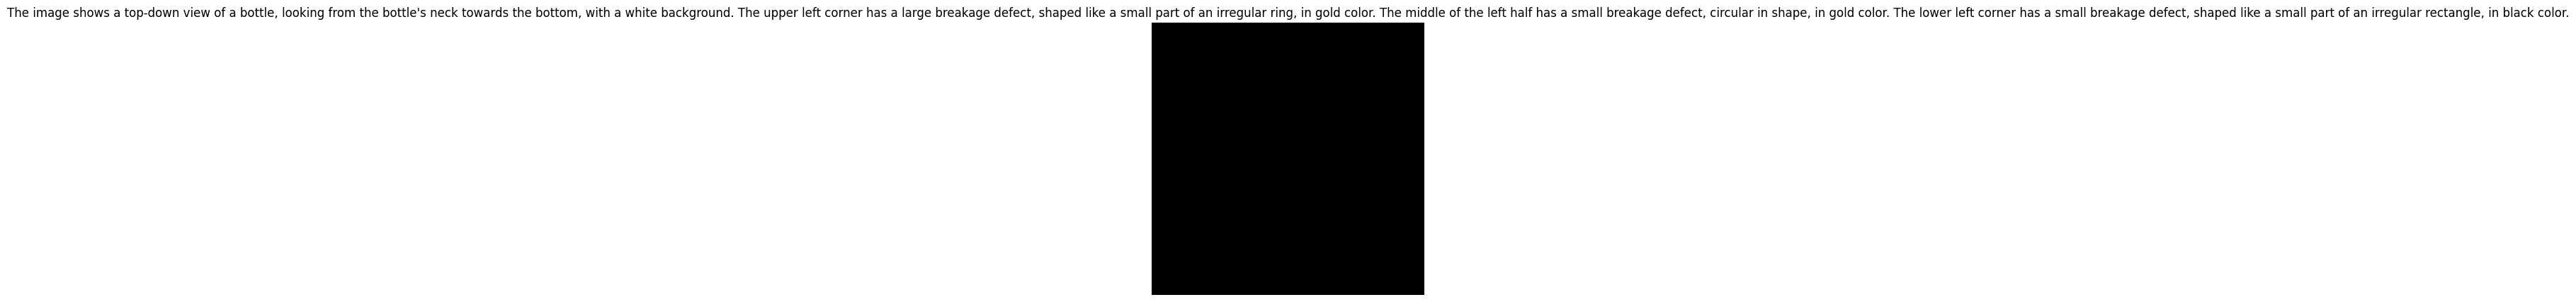

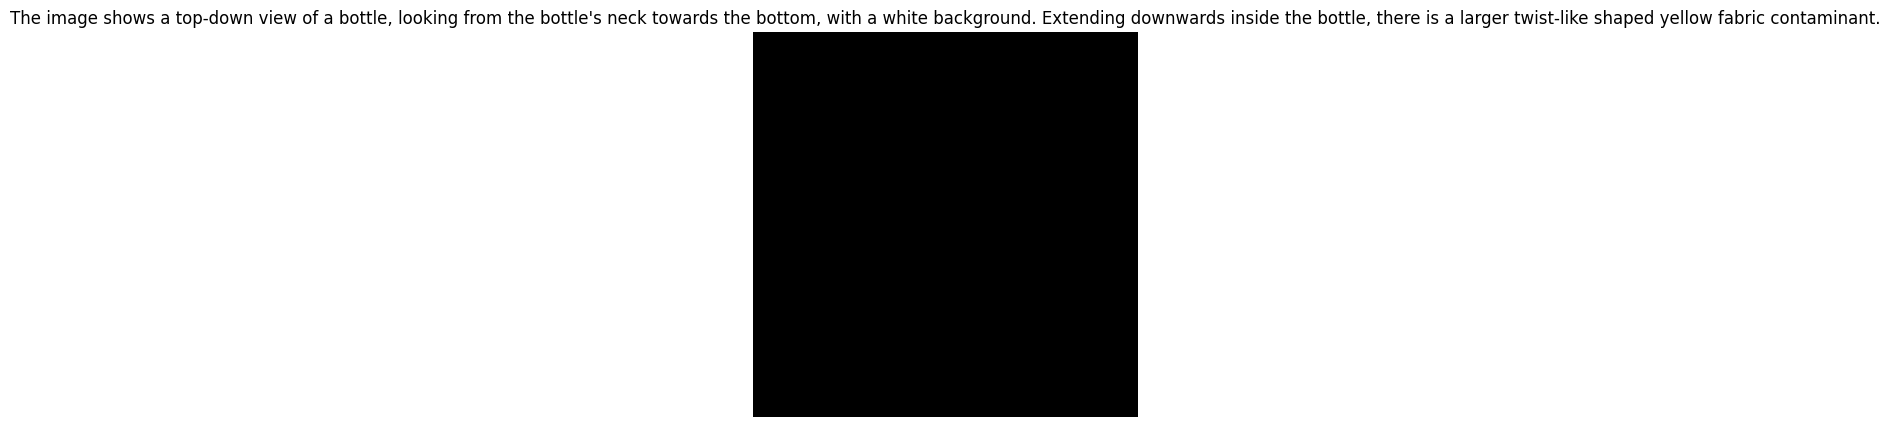

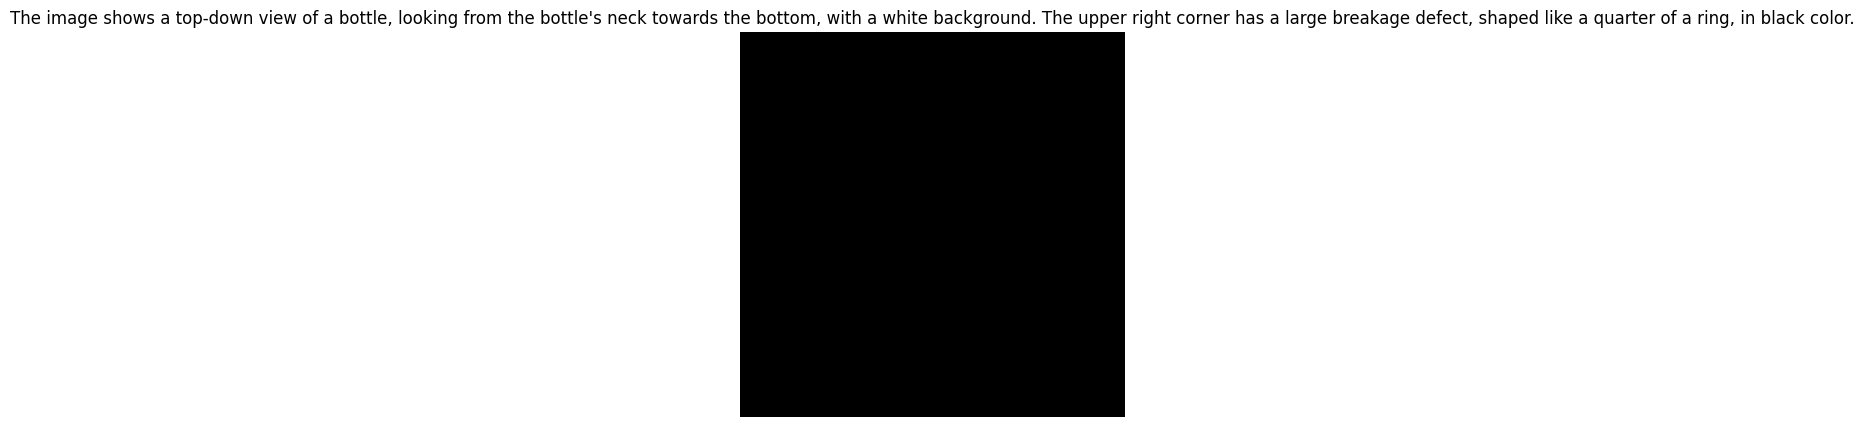

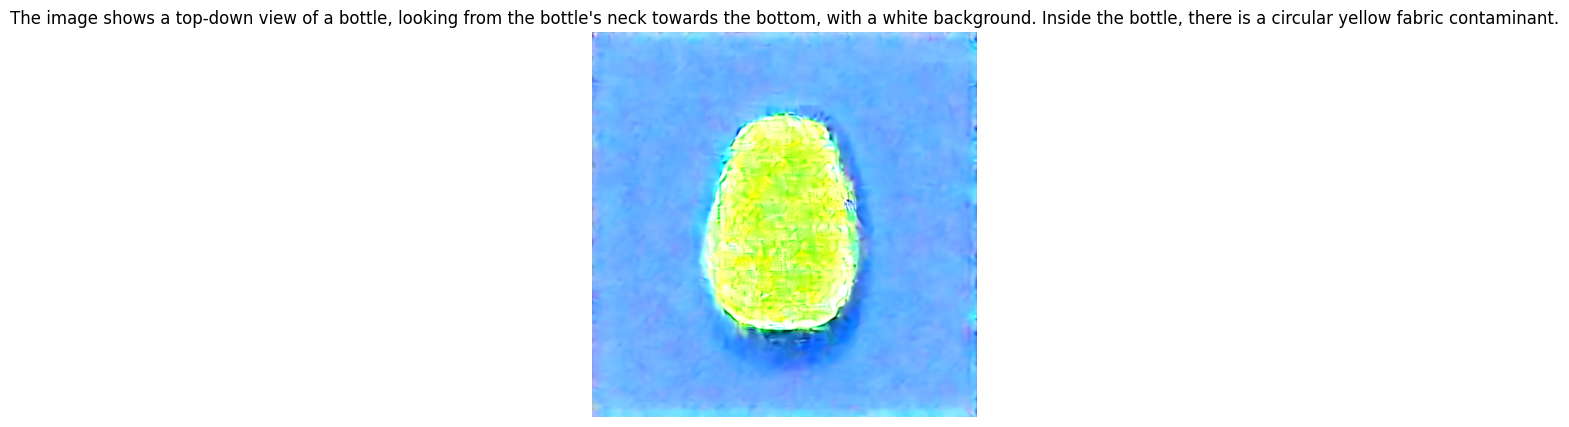

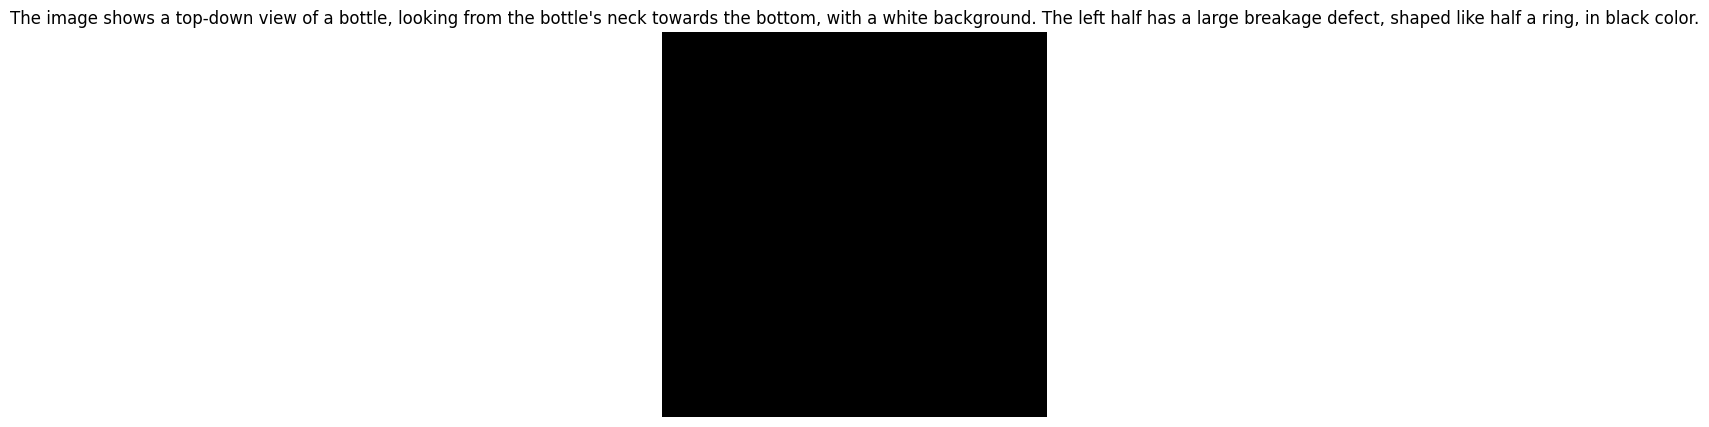

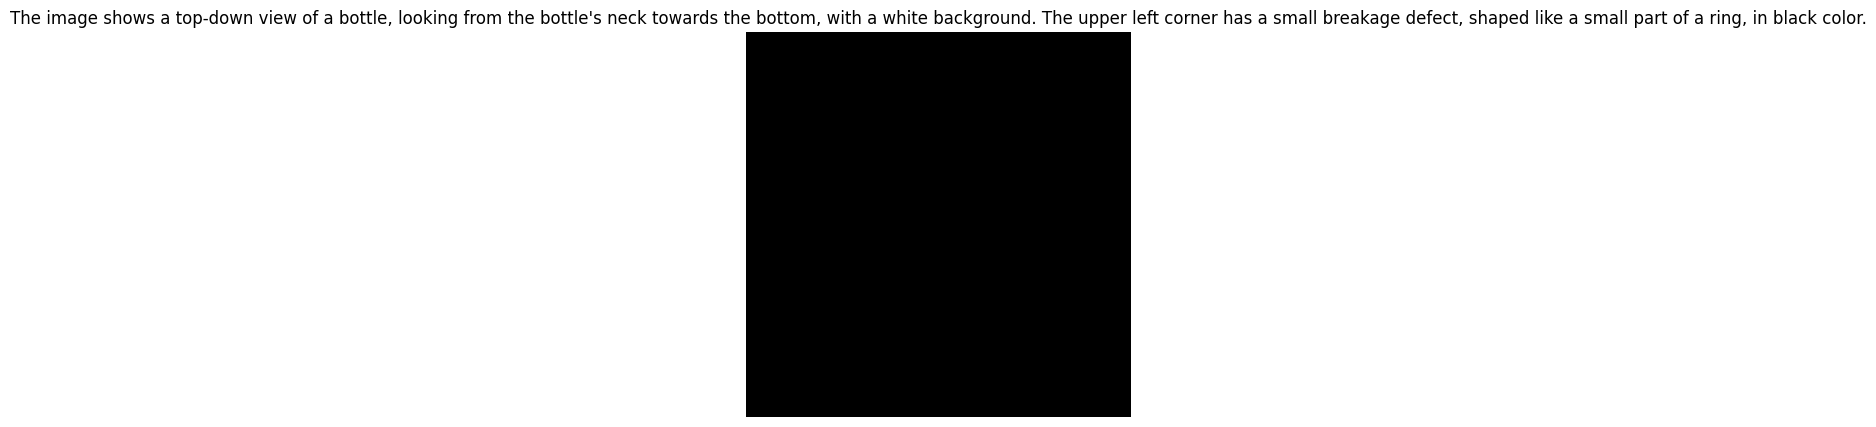

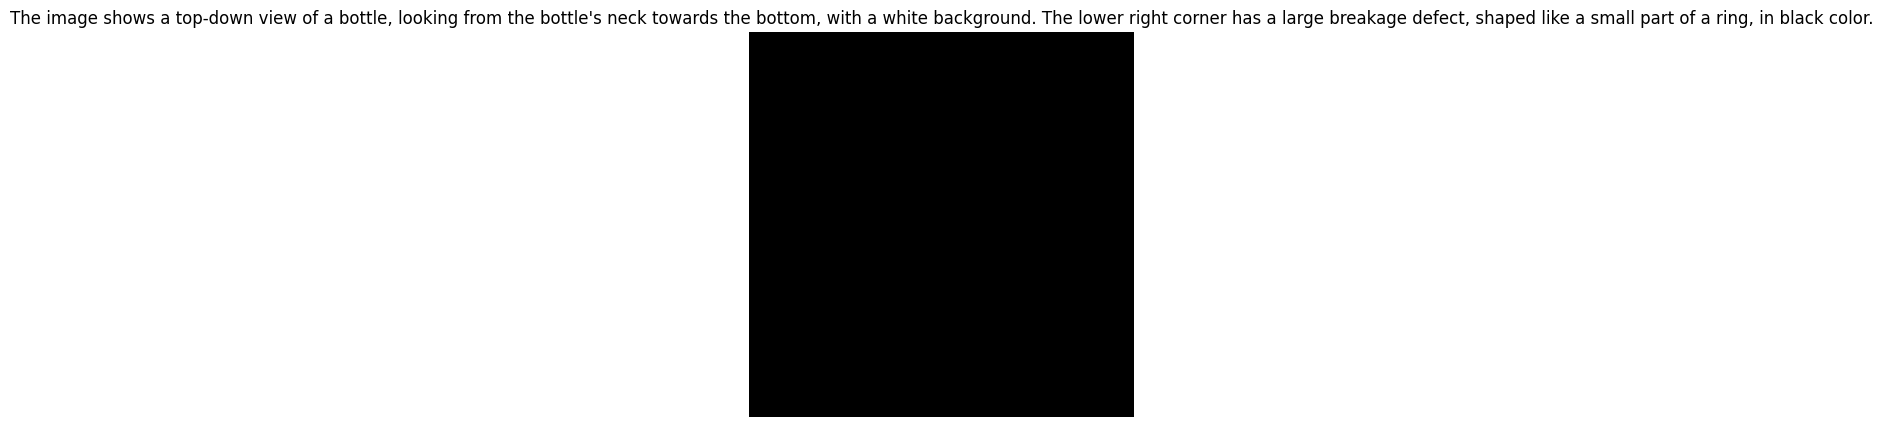

In [23]:
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline
from peft import LoraConfig, get_peft_model

# # Load the pre-trained Stable Diffusion model
# model_id = "stabilityai/stable-diffusion-2"
# pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
# pipe.to("cuda")

# Apply LoRA configuration
# lora_config = LoraConfig(
#     r=8,
#     lora_alpha=32,
#     target_modules=["to_q", "to_k", "to_v", "to_out.0"],
#     lora_dropout=0.1,
#     bias="none"
# )
# unwrapped_model = pipe.unet
# lora_model = get_peft_model(unwrapped_model, lora_config)

# Load the fine-tuned weights
# lora_model.load_state_dict(torch.load("/path/to/fine_tuned_weights.pth"))

# Define the inference function


def generate_image(pipe, prompt, num_inference_steps=20, guidance_scale=10):
    negative_prompt = "image should not be dark and blurry and it should not contain nude, explicit, violent, gore content."
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            image = pipe(prompt, negative_prompt = negative_prompt, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale).images[0]
    return image

# Example prompts
# prompts = ["The bottle has a large breakage defect, shaped like a ring, in gray color.", "A damaged bottle with a crack at the bottom with yellow half ring", ]

# Generate and save images
for i in range(len(val_dataset)):
    prompt = val_dataset[i][2]
    print(f"Generating image for prompt: {prompt}")
    image = generate_image(pipe, prompt)
    image.save(f"generated_image_{i}.png")
    print(f"Image saved as generated_image_{i}.png")

# Display the generated images
for i in range(len(val_dataset)):
    prompt = val_dataset[i][2]
    
    image = Image.open(f"generated_image_{i}.png")
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title(prompt)
    plt.axis("off")
    plt.show()

## Re training with masks:

Image device: cuda:0
Mean device: cuda:0
Std device: cuda:0


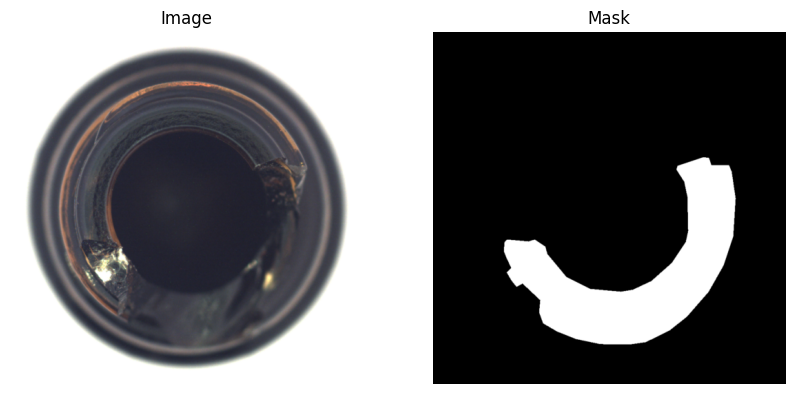

In [31]:
def visualize_training_sample(image, mask):
    """
    Visualize an image and its corresponding mask.
    
    Args:
        image (torch.Tensor): Normalized image tensor (C, H, W).
        mask (torch.Tensor): Mask tensor (H, W).
    """
    # Ensure mean and std are on the same device as the image
    mean = torch.tensor([0.5, 0.5, 0.5], device=image.device).view(3, 1, 1)  # Shape: (C, 1, 1)
    std = torch.tensor([0.5, 0.5, 0.5], device=image.device).view(3, 1, 1)   # Shape: (C, 1, 1)
    print(f"Image device: {image.device}")
    print(f"Mean device: {mean.device}")
    print(f"Std device: {std.device}")
    # Denormalize the image
    denormalized_image = image * std + mean  # Denormalize
    denormalized_image = torch.clamp(denormalized_image, 0, 1)  # Clamp to [0, 1]

    # Convert tensors to NumPy arrays for visualization
    image_np = denormalized_image.permute(1, 2, 0).cpu().numpy()  # Shape: (H, W, C)
    mask_np = mask.squeeze().cpu().numpy()  # Remove channel dimension if present

    # Plot the image and mask
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image_np)
    axes[0].set_title("Image")
    axes[0].axis("off")

    axes[1].imshow(mask_np, cmap="gray")
    axes[1].set_title("Mask")
    axes[1].axis("off")

    plt.show()

# Example usage
for batch in dataloader:
    images, masks, captions = batch  # Extract batch data
    visualize_training_sample(images[0], masks[0])  # Visualize the first sample in the batch
    break  # Stop after visualizing one batch

In [14]:
# Define the modified UNet
class ModifiedUNet2DConditionModel(UNet2DConditionModel):
    def forward(self, sample, timestep, encoder_hidden_states, mask_conditioning=None, return_dict=True):
        # Pass the mask_conditioning to the attention layers
        if mask_conditioning is not None:
            # Resize mask_conditioning to match the spatial dimensions of the attention layers
            mask_conditioning = torch.nn.functional.interpolate(
                mask_conditioning,
                size=sample.shape[2:],  # Match the spatial dimensions of the latents
                mode="nearest"
            )
        
        # Call the original forward method
        output = super().forward(sample, timestep, encoder_hidden_states, return_dict=return_dict)
        
        # Optionally, modify the output based on mask_conditioning
        if mask_conditioning is not None:
            # Example: Weight the output based on the mask
            output.sample = output.sample * mask_conditioning
        
        return output

# Replace the UNet in the pipeline with the modified version
pipe.unet = ModifiedUNet2DConditionModel.from_pretrained(model_id, subfolder="unet", torch_dtype=torch.float16)
pipe.unet.to("cuda")

# Apply LoRA to the modified UNet
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["to_q", "to_k", "to_v", "to_out.0"],
    lora_dropout=0.1,
    bias="none"
)
lora_model = get_peft_model(pipe.unet, lora_config)

In [15]:
print(pipe.unet)

ModifiedUNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): lora.Linear(
                  (base_layer): Linear(in_features=320, out_features=320, bias=False)
                  (lora_dropout): ModuleDict(
                    (default): Dr

In [25]:
accumulation_steps = 1  # Simulate a batch size of 4 * 4 = 16
for epoch in range(5):
    for batch in dataloader:
        optimizer.zero_grad()
        
        # Extract batch data
        images, masks, captions = batch  # batch["image"], batch["mask"], batch["caption"]
        
        # Ensure inputs are in torch.float16 and moved to GPU
        images = images.half().to("cuda")
        masks = masks.half().to("cuda")
        
        # Encode images into latent space
        with torch.cuda.amp.autocast(enabled=False):  # Disable mixed precision for VAE
            image_latents = pipe.vae.encode(images).latent_dist.sample()

        # Ensure masks have the shape [N, C, H, W]
        if masks.dim() == 2:  # If masks have shape [H, W]
            masks = masks.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
        elif masks.dim() == 3:  # If masks have shape [N, H, W]
            masks = masks.unsqueeze(1)  # Add channel dimension

        # Resize masks to match the latent dimensions
        mask_latents = torch.nn.functional.interpolate(
            masks,  # Shape: [N, C, H, W]
            size=image_latents.shape[2:],  # Match latent dimensions (e.g., [64, 64])
            mode="nearest"
        )

        # Generate noise and noisy latents
        noise = torch.randn_like(image_latents)
        timesteps = torch.randint(0, pipe.scheduler.num_train_timesteps, (image_latents.shape[0],), device=image_latents.device).long()
        noisy_latents = pipe.scheduler.add_noise(image_latents, noise, timesteps)
        
        # Preprocess captions
        encoder_hidden_states = preprocess_captions(captions)
        
        # Predict noise
        output = lora_model(noisy_latents, timesteps, encoder_hidden_states=encoder_hidden_states, mask_conditioning=mask_latents)
        noise_pred = output.sample  # Adjust based on output structure
        
        # Compute mask-weighted loss
        mask_weights = torch.nn.functional.interpolate(
            masks,
            size=noise_pred.shape[2:],
            mode="nearest"
        ).squeeze(1)  # Remove channel dimension

        # Align mask weights with noise tensors
        mask_weights = mask_weights.unsqueeze(1)  # Shape: [N, 1, H, W]
        mask_weights = mask_weights.expand(-1, noise_pred.size(1), -1, -1)  # Expand to [N, C, H, W]

        # Weight the loss based on the mask
        loss = torch.mean(mask_weights * ((noise_pred - noise) ** 2))

        # Backward pass
        loss.backward()
        optimizer.step()
    
        print(f"Epoch {epoch}, Loss: {loss.item()}")

C:\Users\adity\AppData\Local\Temp\ipykernel_18920\1746664154.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):  # Disable mixed precision for VAE


Epoch 0, Loss: 0.019775390625
Epoch 0, Loss: 0.03350830078125
Epoch 0, Loss: 0.0185699462890625
Epoch 0, Loss: 0.0024566650390625
Epoch 0, Loss: 0.04095458984375
Epoch 0, Loss: 0.01342010498046875
Epoch 0, Loss: 0.005741119384765625
Epoch 0, Loss: 0.01068115234375
Epoch 0, Loss: 0.0029850006103515625
Epoch 0, Loss: 0.00408172607421875
Epoch 0, Loss: 0.027587890625
Epoch 0, Loss: 0.045318603515625
Epoch 0, Loss: 0.036590576171875
Epoch 0, Loss: 0.03875732421875
Epoch 0, Loss: 0.0170440673828125
Epoch 0, Loss: 0.01434326171875
Epoch 0, Loss: 0.037506103515625
Epoch 0, Loss: 0.014801025390625
Epoch 0, Loss: 0.0251007080078125
Epoch 0, Loss: 0.00348663330078125
Epoch 0, Loss: 0.0173187255859375
Epoch 0, Loss: 0.00815582275390625
Epoch 0, Loss: 0.0126953125
Epoch 0, Loss: 0.0170745849609375
Epoch 0, Loss: 0.0122222900390625
Epoch 0, Loss: 0.00891876220703125
Epoch 0, Loss: 0.002101898193359375
Epoch 0, Loss: 0.0261077880859375
Epoch 0, Loss: 0.0009450912475585938
Epoch 0, Loss: 0.0478210449

In [26]:
from peft import LoraConfig, get_peft_model

# Assuming `lora_model` is your fine-tuned model
output_dir = "../outputs-masked/"
lora_model.save_pretrained(output_dir)
print(f"LoRA weights saved to {output_dir}")

# Save the full pipeline
pipeline_output_dir = "../pipeline-output-masked/"
pipe.save_pretrained(pipeline_output_dir)
print(f"Full pipeline saved to {pipeline_output_dir}")

LoRA weights saved to ../outputs-masked/
Full pipeline saved to ../pipeline-output-masked/


## Inference : with masks

In [27]:
def preprocess_mask(mask, latent_height, latent_width):
    """
    Preprocess the mask to match the latent dimensions.
    
    Args:
        mask (torch.Tensor): Binary or grayscale mask (H, W).
        latent_height (int): Height of the latent space.
        latent_width (int): Width of the latent space.
    
    Returns:
        torch.Tensor: Preprocessed mask tensor (1, H, W).
    """
    # Resize the mask to match the latent dimensions
    mask_tensor = resize(mask.unsqueeze(0), size=(latent_height, latent_width), interpolation=Image.NEAREST)
    return mask_tensor.half().to("cuda")  # Ensure mask is on GPU and in half precision


def create_dummy_mask(latent_height, latent_width):
    """
    Create a dummy mask for inference when no mask is provided.
    
    Args:
        latent_height (int): Height of the latent space.
        latent_width (int): Width of the latent space.
    
    Returns:
        torch.Tensor: Dummy mask tensor (1, H, W).
    """
    # Create an all-one mask (or all-zero if needed)
    dummy_mask = torch.ones((1, 1, latent_height, latent_width), device="cuda", dtype=torch.float16)
    return dummy_mask

def generate_image_with_prompt(pipe, prompt, num_inference_steps=50, guidance_scale=7.5):
    """
    Generate an image using the fine-tuned model with only a prompt.
    
    Args:
        pipe: The StableDiffusionPipeline instance.
        prompt (str): Text prompt describing the desired image.
        num_inference_steps (int): Number of diffusion steps.
        guidance_scale (float): Classifier-free guidance scale.
    
    Returns:
        PIL.Image: Generated image.
    """
    # Encode the prompt into text embeddings
    tokenizer = pipe.tokenizer
    text_encoder = pipe.text_encoder.to("cuda")
    inputs = tokenizer(prompt, padding="max_length", truncation=True, max_length=77, return_tensors="pt")
    encoder_hidden_states = text_encoder(inputs.input_ids.to("cuda"))[0].half()  # Ensure half precision

    # Get latent dimensions
    latent_height, latent_width = 64, 64  # Adjust based on your latent dimensions

    # Create a dummy mask
    dummy_mask = torch.ones((1, 1, latent_height, latent_width), device="cuda", dtype=torch.float16)

    # Generate random noise for the latents
    latents = torch.randn((1, 4, latent_height, latent_width), device="cuda", dtype=torch.float16)

    # Set the scheduler's timesteps
    pipe.scheduler.set_timesteps(num_inference_steps)
    timesteps = pipe.scheduler.timesteps.to("cuda")  # Move timesteps to GPU

    # Scale the initial noise by the standard deviation required by the scheduler
    latents = latents * pipe.scheduler.init_noise_sigma

    # Denoise the latents using the diffusion process
    with torch.no_grad():
        with torch.cuda.amp.autocast(enabled=False):  # Disable mixed precision for stability
            for t in timesteps:
                # Predict the noise residual
                noise_pred = pipe.unet(
                    latents, 
                    t.unsqueeze(0).half(),  # Ensure timestep is in half precision
                    encoder_hidden_states=encoder_hidden_states, 
                    mask_conditioning=dummy_mask
                ).sample
                
                # Update latents (denoising step)
                latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

    # Ensure latents are in float16 before decoding
    latents = latents.half()

    # Decode the latents into an image
    image = pipe.vae.decode(latents)[0]
    image = (image / 2 + 0.5).clamp(0, 1)  # Denormalize

    # Convert to NumPy array
    image = image.detach().permute(0, 2, 3, 1).cpu().numpy()[0]  # Detach before converting to NumPy
    return Image.fromarray((image * 255).astype("uint8"))

In [28]:
# Define the modified UNet to handle masks as additional conditioning
class ModifiedUNet2DConditionModel(pipe.unet.__class__):
    def forward(self, sample, timestep, encoder_hidden_states, mask_conditioning=None, return_dict=True):
        # Pass the mask_conditioning to the attention layers
        if mask_conditioning is not None:
            # Resize mask_conditioning to match the spatial dimensions of the attention layers
            mask_conditioning = torch.nn.functional.interpolate(
                mask_conditioning,
                size=sample.shape[2:],  # Match the spatial dimensions of the latents
                mode="nearest"
            )
        
        # Call the original forward method
        output = super().forward(sample, timestep, encoder_hidden_states, return_dict=return_dict)
        
        # Optionally, modify the output based on mask_conditioning
        if mask_conditioning is not None:
            # Example: Weight the output based on the mask
            output.sample = output.sample * mask_conditioning
        
        return output

# Replace the UNet in the pipeline with the modified version
pipe.unet = ModifiedUNet2DConditionModel.from_config(pipe.unet.config)
pipe.unet.load_state_dict(pipe.unet.state_dict())  # Copy weights from the original UNet
pipe.unet.to("cuda")

# Apply LoRA configuration
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["to_q", "to_k", "to_v", "to_out.0"],
    lora_dropout=0.1,
    bias="none"
)

# Apply LoRA to the modified UNet
lora_model = get_peft_model(pipe.unet, lora_config)

# If the LoRA weights are already applied during training, no need to reload them

C:\Users\adity\AppData\Local\Temp\ipykernel_18920\636785637.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):  # Disable mixed precision for stability


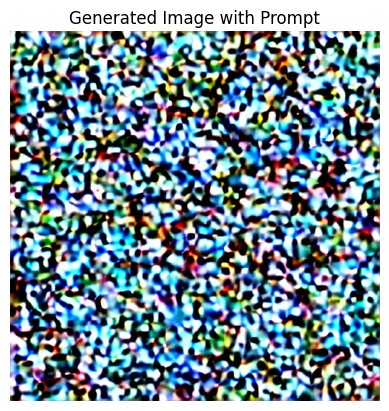

In [29]:
# Example prompt
prompt = "The image shows a top-down view of a bottle, looking from the bottle's neck towards the bottom, with a white background. The bottom right corner has a large breakage defect, shaped like a quarter of a ring, in black color."
pipe.unet = pipe.unet.half().to("cuda")

# Generate the image
generated_image = generate_image_with_prompt(pipe, prompt)

# Save and display the generated image
generated_image.save("prompt_gen-masked-model-1.png")
plt.imshow(generated_image)
plt.title("Generated Image with Prompt")
plt.axis("off")
plt.show()

In [1]:
# Example prompt
prompt = "The image of bottom side of glass bottle with a round crack of black color."
pipe.unet = pipe.unet.half().to("cuda")

# Generate the image
generated_image = generate_image_with_prompt(pipe, prompt)

# Save and display the generated image
generated_image.save("prompt_gen-masked-model-2.png")
plt.imshow(generated_image)
plt.title("Generated Image with Prompt")
plt.axis("off")
plt.show()

NameError: name 'pipe' is not defined